# House pricing on the basis of square footage and realtor assesment

## Introduction

Authors:
 - Nicolas Duc
 - Piotr Kula

#### Goal of this project 
The goal of this project is analysis of the market prices of houses on the basis of the square footage and the realtor's assesment.

The proposed model can be then used to asses if the given price is a good deal and to check whether the house price is comparable to the market standard.

## Data

The data was obtained from kaggle.com.

Dataset contains different types of data such as numner of bedrooms, zipcode, year it was built, we only use the square footage of the living space and the grade that the realtor has given to the house.

The dataset itself contains over 21000 records, however for the purpose of the project we sample 100 records that will later be used.

In [2]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import random as rd
# print(len(pd.read_csv('kc_house_data.csv')))
df = (pd.read_csv("house_data_sampled.csv").sample(100)).reset_index()
# print(df.head())
# df.columns
df['price'].mean()

541517.08

In [3]:

mean_sqft_living = (df['sqft_living']).mean()
mean_grade = (df['grade']).mean()
sd_sqft_living = (df['sqft_living']).std()
print(sd_sqft_living)
print(mean_sqft_living)
sd_grade = (df['grade']).std()
sqft_living_standardized = ((df['sqft_living']).copy())
price_standardized = ((df['price']).copy())
sqft_living_centered = ((df['sqft_living']).copy())

grade_standardized = (df['grade']).copy()
print(sqft_living_standardized)
for i in range(len(df['sqft_living'])):
    sqft_living_centered[i] = ((df['sqft_living'])[i]-mean_sqft_living)
    sqft_living_standardized[i] = ((df['sqft_living'])[i]-mean_sqft_living)/sd_sqft_living
    grade_standardized[i] = (df['grade'][i]-mean_grade)/sd_grade
    price_standardized[i] = (df['price'][i]-(df['price']).mean())/(df['price']).std()
print(sqft_living_standardized.head())
print(sqft_living_standardized[0])
# print(grade_standardized)

864.252149654149
2153.86
0     1490
1     1140
2     2930
3     1400
4     3180
      ... 
95    2000
96    2970
97    1150
98    2090
99    2370
Name: sqft_living, Length: 100, dtype: int64
0   -0.768132
1   -1.173107
2    0.898048
3   -0.872269
4    1.187316
Name: sqft_living, dtype: float64
-0.7681323098422833


In [4]:
grade_moved = ((df['grade']).copy())
for i in range(len(grade_moved)):
    grade_moved[i] = int(grade_moved[i]-6)
print(f"MIN: {grade_moved.min()} MAX: {grade_moved.max()}")

MIN: 0 MAX: 5


In [5]:
mean_price = (df['price']).mean()
print(mean_price)

541517.08


## Model 1 - one parameter

### Prior

The parameters for the prior have been selected on the basis of a 

In [6]:
sqft_linspace = np.linspace(sqft_living_centered.min(),sqft_living_centered.max())
data = {'N': len(sqft_linspace),
        'sqft': sqft_linspace}

In [7]:
one_param_ppc_a = CmdStanModel(stan_file='CommandFiles/one_param_ppc.stan')
one_param_ppc_a_simulated = one_param_ppc_a.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:compiling stan file /home/nicolas/Projects/DA_project/CommandFiles/one_param_ppc.stan to exe file /home/nicolas/Projects/DA_project/CommandFiles/one_param_ppc
INFO:cmdstanpy:compiled model executable: /home/nicolas/Projects/DA_project/CommandFiles/one_param_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


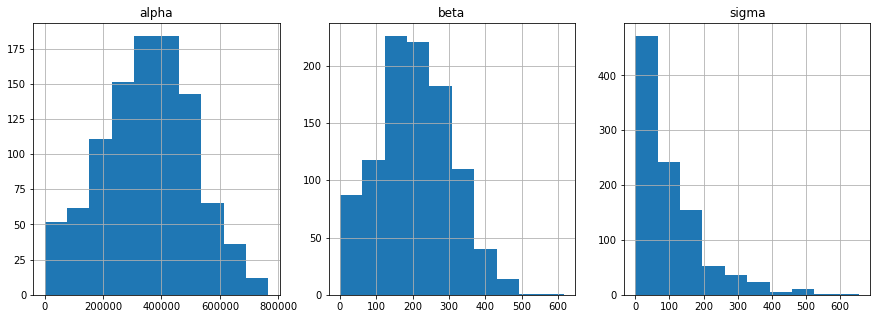

,mean,sd,hdi_3%,hdi_97%
alpha,352321.48,158063.89,0.0,592987.00
beta,206.29,101.33,0.0,364.79
sigma,100.88,99.54,0.0,295.96


In [8]:
alpha_sim = one_param_ppc_a_simulated.stan_variable('alpha')
beta_sim = one_param_ppc_a_simulated.stan_variable('beta')
sigma_sim = one_param_ppc_a_simulated.stan_variable('sigma')
price_sim = one_param_ppc_a_simulated.stan_variable('price')

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].hist(alpha_sim);
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(beta_sim);
axs[1].grid()
axs[1].set_title('beta')
axs[2].hist(sigma_sim);
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

az.summary(one_param_ppc_a_simulated,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

Text(0, 0.5, 'Price [USD]')

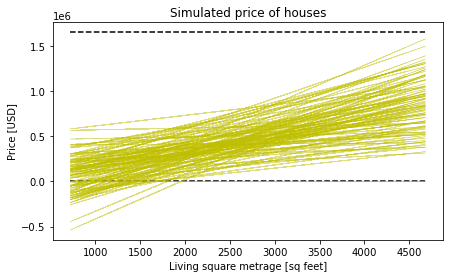

In [9]:
alpha_sim=one_param_ppc_a_simulated.stan_variable('alpha')
beta_sim=one_param_ppc_a_simulated.stan_variable('beta')

# plt.plot(beta_sim)
# plt.title("grade")
# plt.show()
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hlines(
    [0,(df['price']).max()],
    xmin=df['sqft_living'].min(),
    xmax=df['sqft_living'].max(),
    linestyle='--',color='black'
    )
for i in range(100):
    axes.plot(
        df['sqft_living'],
        alpha_sim[i]+beta_sim[i]*sqft_living_centered,
        color = 'y',alpha=0.5,linewidth=0.5
        )
plt.title("Simulated price of houses");
plt.xlabel("Living square metrage [sq feet]")
plt.ylabel("Price [USD]")

### Posterior

In [10]:
data = {'N': len(sqft_living_centered),
        'sqft': sqft_living_centered,
        'price': df['price']}
one_param = CmdStanModel(stan_file='CommandFiles/one_param.stan')
one_param_simulated = one_param.sample(data=data, seed=21370204)

INFO:cmdstanpy:compiling stan file /home/nicolas/Projects/DA_project/CommandFiles/one_param.stan to exe file /home/nicolas/Projects/DA_project/CommandFiles/one_param
INFO:cmdstanpy:compiled model executable: /home/nicolas/Projects/DA_project/CommandFiles/one_param
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


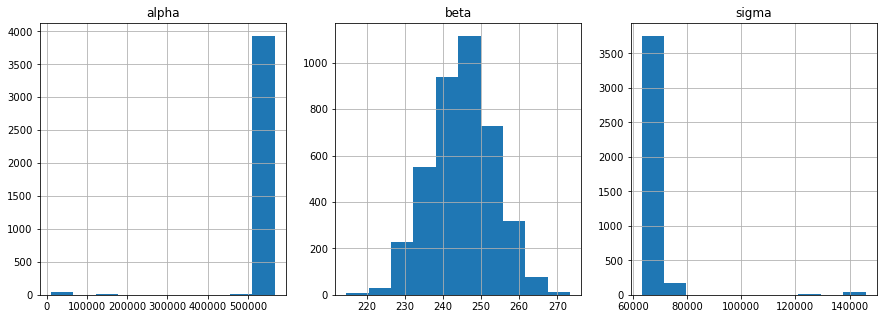

,mean,sd,hdi_3%,hdi_97%
alpha,533904.15,59340.22,527797.00,554936.00
beta,245.11,8.25,229.71,259.75
sigma,70010.31,8960.10,65988.00,71915.20


In [11]:
alpha_sim = one_param_simulated.stan_variable('alpha')
beta_sim = one_param_simulated.stan_variable('beta')
sigma_sim = one_param_simulated.stan_variable('sigma')
price_sim = one_param_simulated.stan_variable('price_sim')

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].hist(alpha_sim)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(beta_sim)
axs[1].grid()
axs[1].set_title('beta')
axs[2].hist(sigma_sim)
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

az.summary(one_param_simulated,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

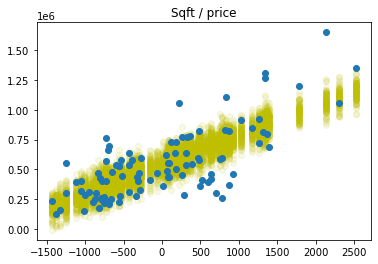

In [12]:
prices_sim=one_param_simulated.stan_variable('price_sim')

# for i in range(0,len(df['sqft_living'])):
for i in range(100):
    plt.scatter(sqft_living_centered, prices_sim[i], color="y", alpha=0.1)

plt.scatter(sqft_living_centered, df["price"])

plt.title("Sqft / price")
plt.show()

## Model 2 - linear grade

### Prior

In [26]:
sqft_linspace = np.linspace(sqft_living_standardized.min(),sqft_living_standardized.max())
grade_linspace = np.linspace(grade_standardized.min(),grade_standardized.max())

data = {'N': len(sqft_linspace),
        'sqft': sqft_linspace,
        'grade': grade_linspace}

two_params_ppc = CmdStanModel(stan_file='CommandFiles/two_params_ppc.stan')
two_params_ppc_simulated = two_params_ppc.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:compiling stan file /home/nicolas/Projects/DA_project/CommandFiles/two_params_ppc.stan to exe file /home/nicolas/Projects/DA_project/CommandFiles/two_params_ppc
INFO:cmdstanpy:compiled model executable: /home/nicolas/Projects/DA_project/CommandFiles/two_params_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


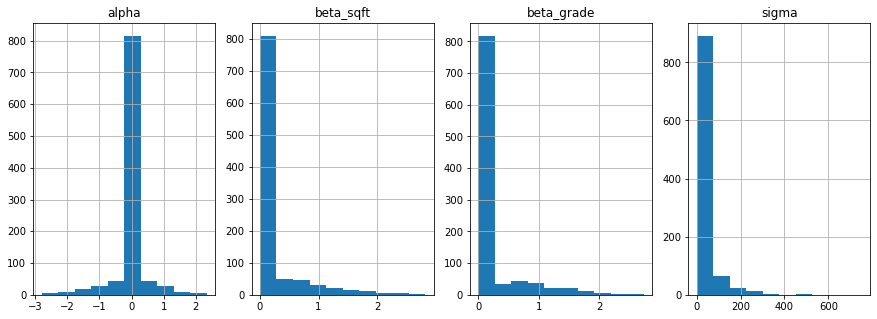

,mean,sd,hdi_3%,hdi_97%
alpha,-0.03,0.48,-0.92,1.34
beta_sqft,0.20,0.47,0.00,1.20
beta_grade,0.19,0.44,0.00,1.19
sigma,23.35,64.51,0.00,128.99


In [27]:
alpha_sim = two_params_ppc_simulated.stan_variable('alpha')
beta_grade_sim = two_params_ppc_simulated.stan_variable('beta_grade')
beta_sqft_sim = two_params_ppc_simulated.stan_variable('beta_sqft')
sigma_sim = two_params_ppc_simulated.stan_variable('sigma')
# price_sim = two_params_ppc_simulated.stan_variable('price_sim')

fig, axs = plt.subplots(1,4)
fig.set_size_inches(15, 5)
axs[0].hist(alpha_sim)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(beta_sqft_sim)
axs[1].grid()
axs[1].set_title('beta_sqft')
axs[2].hist(beta_grade_sim)
axs[2].grid()
axs[2].set_title('beta_grade')
axs[3].hist(sigma_sim)
axs[3].grid()
axs[3].set_title('sigma')
plt.show()

az.summary(two_params_ppc_simulated,var_names=['alpha','beta_sqft', 'beta_grade','sigma'],round_to=2,kind='stats')

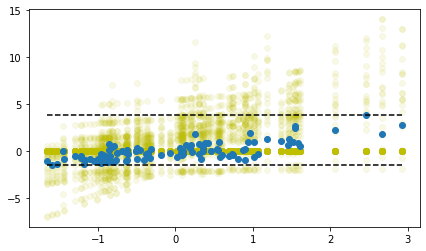

In [31]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hlines(
    [price_standardized.min(),price_standardized.max()],
    xmin=sqft_living_standardized.min(),
    xmax=sqft_living_standardized.max(),
    linestyle='--', color='black'
    )
for i in range(100):
    plt.scatter(
        sqft_living_standardized,
        alpha_sim[i] + beta_sqft_sim[i]*sqft_living_standardized + beta_grade_sim[i]*grade_moved,
        color = 'y', alpha=0.1, linewidth=0.5
        )

plt.scatter(sqft_living_standardized, price_standardized)

### Posterior

In [32]:
data = {'N': len(sqft_living_standardized),
        'sqft_living': sqft_living_standardized,
        'grade': grade_standardized,
        'price': price_standardized}
two_params = CmdStanModel(stan_file='CommandFiles/two_params.stan')
two_params_simulated = two_params.sample(data=data, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


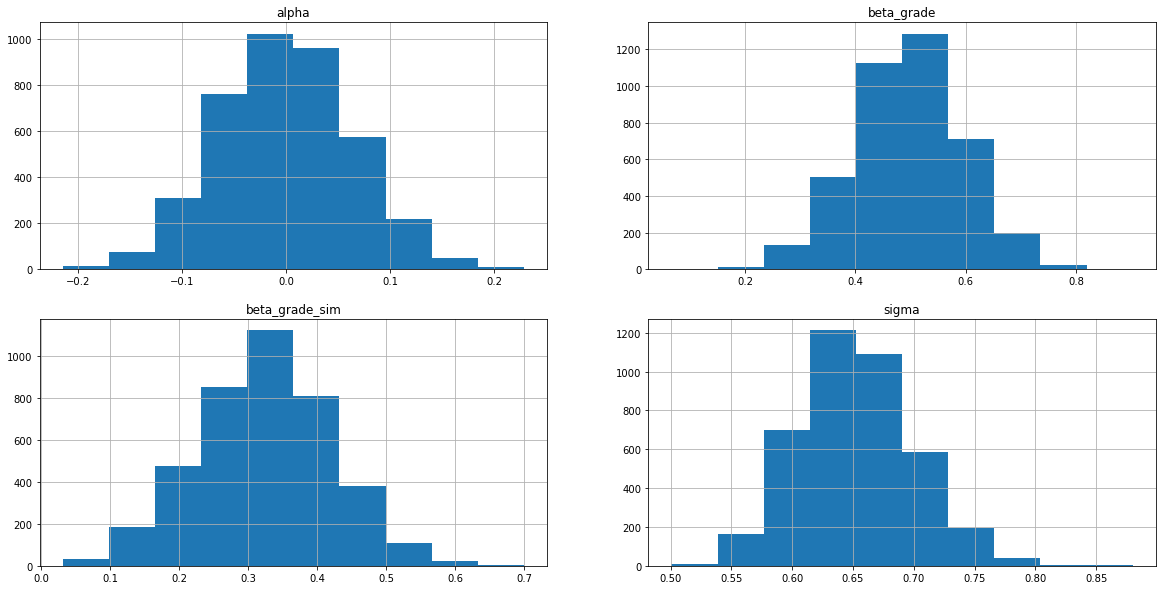

,mean,sd,hdi_3%,hdi_97%
alpha,0.00,0.06,-0.12,0.12
beta_sqft_living,0.50,0.10,0.31,0.68
beta_grade,0.32,0.10,0.14,0.50
sigma,0.65,0.05,0.57,0.74


In [36]:
alpha_sim = two_params_simulated.stan_variable('alpha')
beta_living_sim = two_params_simulated.stan_variable('beta_sqft_living')
beta_grade_sim = two_params_simulated.stan_variable('beta_grade')
sigma_sim = two_params_simulated.stan_variable('sigma')
price_sim = two_params_simulated.stan_variable('prices')

fig, axs = plt.subplots(2,2)
fig.set_size_inches(20, 10)
axs[0][0].hist(alpha_sim)
axs[0][0].grid()
axs[0][0].set_title('alpha')
axs[0][1].hist(beta_living_sim)
axs[0][1].grid()
axs[0][1].set_title('beta_grade')
axs[1][0].hist(beta_grade_sim)
axs[1][0].grid()
axs[1][0].set_title('beta_grade_sim')
axs[1][1].hist(sigma_sim)
axs[1][1].grid()
axs[1][1].set_title('sigma')
plt.show()

az.summary(
    two_params_simulated,
    var_names=['alpha','beta_sqft_living', 'beta_grade','sigma'],
    round_to=2,kind='stats'
    )

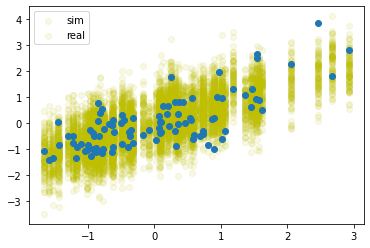

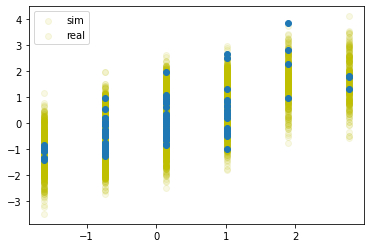

In [37]:
price_sim = two_params_simulated.stan_variable('prices')


for i in range(100):
    plt.scatter(sqft_living_standardized, price_sim[i], color="y", alpha=0.1)

plt.scatter(sqft_living_standardized,price_standardized)
plt.legend(["sim", "real"])
plt.show()

for i in range(100):
    plt.scatter(grade_standardized, price_sim[i], color="y", alpha=0.1)
plt.scatter(grade_standardized,price_standardized)
plt.legend(["sim", "real"])

## Model 3 - discrete grade

### Prior

In [19]:
sqft_linspace = np.linspace(sqft_living_standardized.min(),sqft_living_standardized.max())
grade_in = grade_moved.sample(50).sort_values()

data = {'N': len(sqft_linspace),
        'sqft': sqft_linspace,
        'grade': grade_in}
two_params_discrete_ppc = CmdStanModel(stan_file='CommandFiles/two_param_discrete_ppc.stan')
two_params_discrete_ppc_simulated = two_params_discrete_ppc.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:compiling stan file /home/nicolas/Projects/DA_project/CommandFiles/two_param_discrete_ppc.stan to exe file /home/nicolas/Projects/DA_project/CommandFiles/two_param_discrete_ppc
ERROR:cmdstanpy:Stan program failed to compile:
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/nicolas/Projects/DA_project/CommandFiles/two_param_discrete_ppc.hpp /home/nicolas/Projects/DA_project/CommandFiles/two_param_discrete_ppc.stan
Semantic error in '/home/nicolas/Projects/DA_project/CommandFiles/two_param_discrete_ppc.stan', line 17, column 69 to column 79:
   -------------------------------------------------
    15:      vector [N] price;
    16:      for (i in 1:N) {
    17:          price[i] = normal_rng(alpha + sqft[i]*beta_sqft + beta_grade[grade[i]+1], sigma);
                                                                              ^
    18:      }
    19:  }
   -------------------------------------------------

Index must be of type int or int[] or must be a ran

ValueError: Unable to compile Stan model file: /home/nicolas/Projects/DA_project/CommandFiles/two_param_discrete_ppc.stan.

In [ ]:
alpha_sim = two_params_discrete_ppc_simulated.stan_variable('alpha')
beta_grade_sim = two_params_discrete_ppc_simulated.stan_variable('beta_grade')
beta_sqft_sim = two_params_discrete_ppc_simulated.stan_variable('beta_sqft')
sigma_sim = two_params_discrete_ppc_simulated.stan_variable('sigma')
# price_sim = two_params_discrete_ppc_simulated.stan_variable('price_sim')

fig, axs = plt.subplots(1,4)
fig.set_size_inches(15, 5)
axs[0].hist(alpha_sim)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(beta_sqft_sim)
axs[1].grid()
axs[1].set_title('beta_sqft')
axs[2].hist(beta_grade_sim)
axs[2].grid()
axs[2].set_title('beta_grade')
axs[3].hist(sigma_sim)
axs[3].grid()
axs[3].set_title('sigma')
plt.show()

az.summary(two_params_ppc_simulated,var_names=['alpha','beta_sqft', 'beta_grade','sigma'],round_to=2,kind='stats')

### Posterior

In [ ]:
data = {'N': len(sqft_living_standardized),
        'sqft_living': sqft_living_standardized,
        'grade': grade_moved,
        'price': price_standardized}
two_params_discrete = CmdStanModel(stan_file='CommandFiles/two_param_discrete.stan')
two_params_simulated_discrete = two_params_discrete.sample(data=data, seed=21370204)

INFO:cmdstanpy:compiling stan file C:\STUFF\8th_semester\DA_project\CommandFiles\two_param_discrete.stan to exe file C:\STUFF\8th_semester\DA_project\CommandFiles\two_param_discrete.exe
INFO:cmdstanpy:compiled model executable: C:\STUFF\8th_semester\DA_project\CommandFiles\two_param_discrete.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/STUFF/8th_semester/DA_project/CommandFiles/two_param_discrete.hpp C:/STUFF/8th_semester/DA_project/CommandFiles/two_param_discrete.stan
Warning in 'C:/STUFF/8th_semester/DA_project/CommandFiles/two_param_discrete.stan', line 4, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/STUFF/8th_semester/DA_project/CommandFiles/two_param_discrete.stan', line 5, column 4: Declaration
    of arrays by placing brackets after


INFO:cmdstanpy:CmdStan done processing.


## Comparison of models

### Comparison of all three models

In [ ]:
idata1 = az.from_cmdstanpy(posterior = one_param_simulated, log_likelihood = "log_lik");
idata2 = az.from_cmdstanpy(posterior = two_params_simulated, log_likelihood = "log_lik");
idata3 = az.from_cmdstanpy(posterior=two_params_simulated_discrete, log_likelihood="log_lik") ;
compare_dict = {"one_param_model": idata1, "two_param_model": idata2, "two_param_discrete": idata3};

out_loo = az.compare(compare_dict, ic = "loo");
out_waic = az.compare(compare_dict, ic = "waic"); # loo stands for leave one out cross validation

az.plot_compare(out_loo)
out_loo

az.plot_compare(out_waic)
out_waic

### Comparison of models with two parameters

In [ ]:
# Comparing 2 models: model_1 - with AGE only, model_2 - with AGE and BMI
idata2 = az.from_cmdstanpy(posterior = two_params_simulated, log_likelihood = "log_lik")
idata3 = az.from_cmdstanpy(posterior=two_params_simulated_discrete, log_likelihood="log_lik") 
compare_dict = {"two_param_model": idata2, "two_param_discrete": idata3}

out_loo = az.compare(compare_dict, ic = "loo")
out_waic = az.compare(compare_dict, ic = "waic") # loo stands for leave one out cross validation

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
two_param_discrete,0,-99.979261,8.668769,0.000000,0.559463,8.685397,0.000000,False,log
two_param_model,1,-100.917468,4.617652,0.938207,0.440537,8.754549,4.543933,False,log


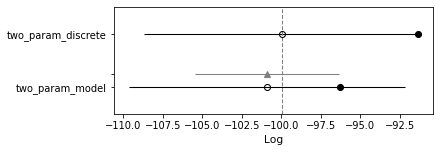

In [ ]:
az.plot_compare(out_loo)
out_loo

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
two_param_model,0,-99.745539,8.435046,0.000000,1.000000e+00,8.658074,0.000000,True,log
one_param_model,1,-1614.114163,27.789668,1514.368625,1.158639e-09,65.436963,58.632821,True,log


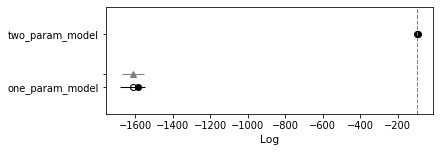

In [ ]:
az.plot_compare(out_waic)
out_waic


1. The warnings are most likey caused by the outliers in the data: https://discourse.mc-stan.org/t/number-of-points-with-pareto-k-0-7-increases-when-a-subset-of-the-data-set-is-used/91081.